# Predicting Individual IMFs with LSTM Networks

In [1]:
from functools import lru_cache
from pathlib import Path
from typing import Tuple

import gsod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.data.ops.dataset_ops import MapDataset

gsod.enable_svg_graphing()
gsod.suppress_tf_log()

Init Plugin
Init Graph Optimizer
Init Kernel


Load dataset.

In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
interpolated = ds.read_continuous(stn=STATION, year="????", interpolate=True)
interpolated.describe().T

,count,mean,std,min,25%,50%,75%,max
STN,32353.0,722860.000000,0.000000,722860.0,722860.0,722860.0,722860.0,722860.00
WBAN,32353.0,27460.475597,17743.805133,23119.0,23119.0,23119.0,23119.0,99999.00
TEMP,32353.0,62.574142,11.057028,31.1,53.9,61.5,71.3,105.40
TEMP_COUNT,32353.0,23.372238,2.833980,4.0,24.0,24.0,24.0,24.00
DEWP,32353.0,376.829138,1790.077986,-14.4,37.9,46.5,53.0,9999.90
DEWP_COUNT,32353.0,23.058743,4.397425,0.0,24.0,24.0,24.0,24.00
SLP,32353.0,1103.903378,882.245015,994.3,1012.1,1014.4,1017.6,9999.90
SLP_COUNT,32353.0,18.965212,7.206642,0.0,8.0,24.0,24.0,24.00
STP,32353.0,5615.898133,4517.543302,939.4,960.3,9999.9,9999.9,9999.90
STP_COUNT,32353.0,9.305366,10.873508,0.0,0.0,0.0,24.0,24.00


Load CEEMDAN decomposition results.
Run `10-EMD.ipynb` first if you havn't done so.

In [3]:
imfs_array = np.load("runtime/imfs.npy")
imfs = pd.DataFrame(imfs_array.T,
                    columns=[f"IMF_{n+1}" for n in range(len(imfs_array))])
imfs.index = interpolated.index
dataframe = pd.merge(interpolated, imfs, how="left",
                     left_index=True, right_index=True)
imfs.describe().T

,count,mean,std,min,25%,50%,75%,max
IMF_1,32353.0,-0.009430,1.445604,-8.087523,-0.937529,-0.013539,0.892774,7.803147
IMF_2,32353.0,-0.000710,0.226400,-1.986657,-0.147704,-0.002119,0.144548,2.557312
IMF_3,32353.0,-0.002454,1.171615,-6.026996,-0.733010,-0.013655,0.721976,5.444142
IMF_4,32353.0,-0.007266,1.717885,-9.450906,-1.154699,-0.017321,1.131476,9.775368
IMF_5,32353.0,-0.007274,1.716266,-7.401238,-1.194221,-0.019496,1.175146,6.731860
IMF_6,32353.0,-0.005901,1.587129,-5.786507,-1.135891,0.000732,1.119851,5.955110
IMF_7,32353.0,-0.003076,1.449131,-4.943888,-1.025639,-0.001348,1.046936,5.523331
IMF_8,32353.0,0.002960,1.185140,-4.647451,-0.801599,-0.004280,0.826147,4.903218
IMF_9,32353.0,-0.618600,6.772349,-13.748307,-6.355380,-1.847897,5.554219,14.069952
IMF_10,32353.0,-0.030497,2.982550,-7.628524,-2.406159,-0.043325,2.330340,6.980427


Sliding Window Generator.
Mostly from [TensorFlow Time Series Example](https://www.tensorflow.org/tutorials/structured_data/time_series),
but also includes my own comments and modifications.

In [4]:
class WindowGenerator:
    """Build a window from the data for training.

    Parameters
    ----------
        df: DataFrame containing the dataset.
        input_width: Width of the feature input.
        label_width: Width of the outputs.
        shift: Shift (of the end) between the input window
               and the output window.
        batch_size: Size of training batches.
        label_columns: List of columns to be used as the label.

    Example
    -------
                       | - - total size - - |
        input_indices: 0 1 2 3 4 5
        output_indices:        4 5 6 7 8 9 10
                       |  input  | - shft - |
                               | - output - |
    """

    def __init__(self, df: pd.DataFrame, input_width: int,
                 label_width: int, shift: int, batch_size: int,
                 label_columns=None):
        # Split the dataset and store it
        n = len(df)
        self.train_df = df[0:int(n*0.7)]        # 70%
        self.val_df = df[int(n*0.7):int(n*0.9)]  # 20%
        self.test_df = df[int(n*0.9):]          # 10%

        # Work out the label column indices.
        self.column_indices = {name: i for i, name in
                               enumerate(self.train_df.columns)}
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.batch_size = batch_size

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[
            self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[
            self.labels_slice]

    def __repr__(self):
        """Print Window information."""
        return "\n".join([
            f"Total window size: {self.total_window_size}",
            f"Input indices: {self.input_indices}",
            f"Label indices: {self.label_indices}",
            f"Label column name(s): {self.label_columns}"])

    def make_dataset(self, data: pd.DataFrame) -> MapDataset:
        """Generate windowed dataset for training from continuous dataset.

        Parameters
        ---------
        data: DataFrame containing the continuous dataset.

        Returns
        -------
        MapDataset
            Pair of (input, label)
            where the shape of input is (n, input_width, n_columns)
            and the shape of label is (n, label_width, n_columns)
        """
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=self.batch_size,)
        ds = ds.map(self.split_window)
        return ds

    @property
    def train(self):
        """Make training dataset."""
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        """Make validation dataset."""
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        """Make testing dataset."""
        return self.make_dataset(self.test_df)

    @lru_cache
    def get_example(self,
                    dataset: str = "train") -> Tuple[tf.Tensor, tf.Tensor]:
        """Get and cache an example batch of `inputs, labels` for plotting.

        Parameters
        ----------
            dataset: one of "train", "val", or "test"

        Returns
        -------
        Tuple[Tensor, Tensor]
            Pair of (input, label), respectively of shape
            (batch_size, input_size, n_feature) and
            (batch_size, label_size, n_feature).
        """
        return next(iter(getattr(self, dataset)))

    def split_window(self, features: tf.Tensor) -> Tuple:
        """Magic. Something that I don't understand. Comment & typing TODO."""
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]]
                    for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(
        self,
        model: tf.keras.Model = None,
        plot_col: str = None,
        max_subplots: int = 3,
        dataset: str = "train"
    ):
        """Plot the specified dataset and its training results.

        Parameters
        ----------
            model: Trained model.
            plot_col: Index of the feature column to plot.
            max_subplots: Maximum number of subplots.
            dataset: Name of the set.
        """
        # Generate examples from the specified dataset
        inputs, labels = self.get_example(dataset)
        # Select the first feature if not specified
        plot_col = plot_col if plot_col is not None else list(
            self.column_indices.keys())[0]
        plot_col_index = self.column_indices[plot_col]
        # len(inputs) is batch size
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f"{plot_col}")
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label="Inputs", marker=".", zorder=-10)
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(
                    plot_col, None)
            else:
                label_col_index = plot_col_index
            if label_col_index is None:
                continue
            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors="k", label="Labels", c="#2ca02c", s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices,
                            predictions[n, :, label_col_index],
                            marker="X", edgecolors="k", label="Predictions",
                            c="#ff7f0e", s=64)
            if n == 0:
                plt.legend()
        plt.suptitle(f"LSTM Network Samples for {plot_col} "
                     + f"{dataset.capitalize()} Set - Station {STATION}")
        plt.xlabel("Days")

Specification for the LSTM model, training parameters, and helper functions.

In [5]:
WIDTH = 7
MAX_EPOCHS = 100
N_BATCH = 64
# Features other than the IMF
# "DEWP", , "STP", "VISIB", "WDSP", "MXSPD", "GUST", "MAX", "MIN", "PRCP", "SNDP"
OTHER_FEATURES = []


def build_compile_model() -> tf.keras.Model:
    """Specify and compile a model."""
    input_layer = tf.keras.Input(
        # Enable to use stateful model
        # batch_shape=(N_BATCH, WIDTH, len(OTHER_FEATURES) + 1)
        shape=(WIDTH, len(OTHER_FEATURES) + 1)
    )
    lstm = tf.keras.layers.Dense(
        N_BATCH * WIDTH * (len(OTHER_FEATURES) + 1), activation="tanh"
    )(input_layer)
    # Shape [batch, time, features] => [batch, time, lstm_units]
    lstm = tf.keras.layers.LSTM(
        N_BATCH, return_sequences=True,
        # stateful=True,
        dropout=0., recurrent_dropout=0.3
    )(lstm)
    lstm = tf.keras.layers.LSTM(
        N_BATCH, return_sequences=True,
        # stateful=True,
        dropout=0., recurrent_dropout=0.2
    )(lstm)
    # Shape => [batch, time, features]
    lstm = tf.keras.layers.Dense(units=1)(lstm)
    model = tf.keras.Model(inputs=input_layer, outputs=lstm)
    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model


def fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )
    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping],
        verbose=0, shuffle = False
    )
    return history

In [6]:
val_performance = {}
performance = {}
save_path_template = "runtime/LSTM_{imf_name}.h5"
no_reload = False

Train each IMFs with its own models. In my case, CPU is faster.

Training IMF_1Metal device set to: Apple M1

Validating IMF_1
101/101 [==============================] - 1s 4ms/step - loss: 1.2472 - mean_absolute_error: 0.8488
Testing IMF_1
Training IMF_2
Validating IMF_2
101/101 [==============================] - 1s 4ms/step - loss: 0.0214 - mean_absolute_error: 0.1105
Testing IMF_2
Training IMF_3
Validating IMF_3
101/101 [==============================] - 1s 4ms/step - loss: 0.3115 - mean_absolute_error: 0.4190
Testing IMF_3
Training IMF_4
Validating IMF_4
101/101 [==============================] - 1s 4ms/step - loss: 0.1718 - mean_absolute_error: 0.2607
Testing IMF_4
Training IMF_5
Validating IMF_5
101/101 [==============================] - 1s 4ms/step - loss: 0.0599 - mean_absolute_error: 0.1310
Testing IMF_5
Training IMF_6
Validating IMF_6
101/101 [==============================] - 1s 4ms/step - loss: 0.0186 - mean_absolute_error: 0.0718
Testing IMF_6
Training IMF_7
Validating IMF_7
101/101 [==============================] - 1s 4ms/step - loss:

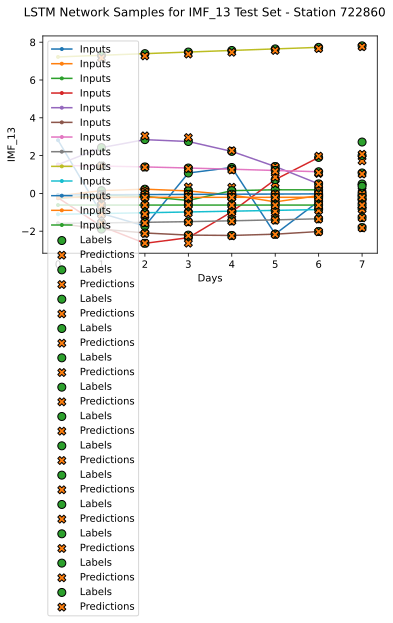

In [7]:
with tf.device("/cpu:0"):
    # Skip the last (trend) IMF
    for imf_name in (f"IMF_{n}" for n in range(1, len(imfs.T))):
        save_path = None
        if save_path_template is not None:
            save_path = Path(save_path_template.format(imf_name=imf_name))
        print(f"Training {imf_name}")
        wide_window = WindowGenerator(
            df=dataframe[[imf_name] + OTHER_FEATURES],
            input_width=WIDTH, label_width=WIDTH, shift=1,
            batch_size=N_BATCH, label_columns=[imf_name]
        )
        if save_path is not None and save_path.exists() and not no_reload:
            lstm_model = tf.keras.models.load_model(save_path)
        else:
            lstm_model = build_compile_model()
            fit(lstm_model, wide_window)
        print(f"Validating {imf_name}")
        val_performance[f"{imf_name}"] = lstm_model.evaluate(wide_window.val)
        print(f"Testing {imf_name}")
        performance[f"{imf_name}"] = lstm_model.evaluate(wide_window.test,
                                                         verbose=0)
        wide_window.plot(model=lstm_model, max_subplots=1,
                         plot_col=imf_name, dataset="test")
        if save_path is not None:
            lstm_model.save(save_path)
        tf.keras.backend.clear_session()

Show the metrics of the final result.

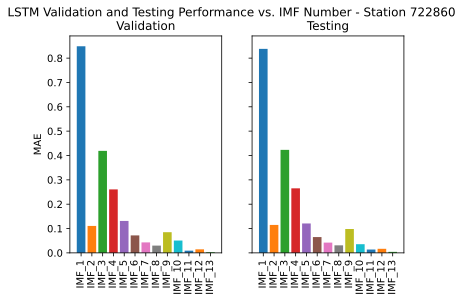

In [8]:
fig, ax = plt.subplots(1, 2, sharey=True)
plt.suptitle(f"LSTM Validation and Testing Performance vs. IMF Number "
             + f"- Station {STATION}")
ax[0].yaxis.label.set_text("MAE")
ax[0].title.set_text("Validation")
ax[0].tick_params("x", labelrotation=90)
for perf in val_performance.keys():
    ax[0].bar(perf, val_performance[perf][1])
ax[1].title.set_text("Testing")
ax[1].tick_params("x", labelrotation=90)
for perf in performance.keys():
    ax[1].bar(perf, performance[perf][1])

Save the metrics for comparison

In [9]:
import json
json.dump({"val": val_performance, "test": performance}, open("runtime/lstm_perf.json", "w"))